In [2]:
import matplotlib
from pylab import * # For adjusting frame width only
import matplotlib.ticker as mticker
from matplotlib import pyplot as plt

# some wrapper function to make plots neat
'''
Make frame thicker, make tick pointing inside, make tick thicker
default frame width is 2, default tick width is 1.5
'''
def frame_tick(frame_width = 2, tick_width = 1.5):
    ax = gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(frame_width)
    plt.tick_params(direction = 'in', 
                    width = tick_width)

'''
legend:
default location : upper left
default fontsize: 8
Frame is always off
'''
def legend(location = 'upper left', fontsize = 8):
    plt.legend(loc = location, fontsize = fontsize, frameon = False)
    
'''
savefig:
bbox_inches is always tight
'''
def savefig(filename):
    plt.savefig(filename, bbox_inches = 'tight')

# Evaluation of GAMD-small trained on LJ fluid data

In [11]:
import sys, os
sys.path.append(os.path.join('../',os.path.dirname(os.path.abspath(''))))

from nn_module import SimpleMDNetNew
from train_utils import LJDataNew
from train_network_lj import ParticleNetLightning, NUM_OF_ATOMS
import torch
import numpy as np
from torch.utils.data import DataLoader
from types import SimpleNamespace

dataset = LJDataNew(dataset_path='md_dataset/lj_data',
                   sample_num=1000,
                   case_prefix='data_',
                   seed_num=10,
                   m_num=NUM_OF_ATOMS,
                   mode='test')
dataloader = DataLoader(dataset, num_workers=2, batch_size=1, shuffle=False,
                          collate_fn=
                          lambda batches: {
                              'pos': [batch['pos'] for batch in batches],
                              'forces': [batch['forces'] for batch in batches],
                          })

PATH = './model_ckpt_lj/checkpoint_28.ckpt'
SCALER_CKPT = './model_ckpt_lj/scaler_28.npz'
args = SimpleNamespace(use_layer_norm=True,
                       encoding_size=128,
                       hidden_dim=128,
                       edge_embedding_dim=128,
                      drop_edge=False,
                       conv_layer=4,
                      rotate_aug=False,
                       update_edge=False,
                       use_part=False,
                      data_dir='',
                      loss='mae')
model = ParticleNetLightning(args).load_from_checkpoint(PATH, args=args)
model.load_training_stats(SCALER_CKPT)
model.cuda()
model.eval()
print('')

Using following set of hyper-parameters
{'encoding_size': 128, 'out_feats': 3, 'hidden_dim': 128, 'edge_embedding_dim': 128, 'conv_layer': 4, 'drop_edge': False, 'use_layer_norm': True, 'box_size': 27.27}
Using following set of hyper-parameters
{'encoding_size': 128, 'out_feats': 3, 'hidden_dim': 128, 'edge_embedding_dim': 128, 'conv_layer': 4, 'drop_edge': False, 'use_layer_norm': True, 'box_size': 27.27}



In [12]:
cos_vals = []
force = []
force_gt = []
mae = []
se = []
num = []
with torch.no_grad():
    count = 0
    for i_batch, batch in enumerate(dataloader):

        pos = batch['pos']
        gt = torch.from_numpy(batch['forces'][0]).float().cuda()

        force_np = model.predict_forces(pos[0])
        force_tsr = torch.from_numpy(force_np).cuda()
        cos_val = torch.sum(force_tsr * gt, dim=1) / (force_tsr.norm(dim=1)*gt.norm(dim=1))
        force_tsr = force_tsr.view(-1, 3)*(0.0010364)  # KJ/mol to ev/A
        gt = gt.view(-1, 3)*(0.0010364)
        force += [force_tsr.cpu().numpy()]
        force_gt += [gt.cpu().numpy()]
        mae += [torch.sum(torch.mean(torch.abs(force_tsr - gt), dim=1)).cpu().numpy()]
        se += [torch.sum(torch.mean((force_tsr-gt)**2, dim=1)).cpu().numpy()]
        num += [pos[0].shape[0]]
        cos_vals += [cos_val]
        if count%200 == 0:
            print(f"Finished {i_batch}")
        count += 1
        
print(f'cos value: {torch.mean(torch.cat(cos_vals))}')
print(f'MAE {np.sum(mae) / np.sum(num)}')
print(f'std of MAE per sample: {np.std([mae[i]/num[i] for i in range(len(num))])}')
print(f'RMSE: {np.sqrt(np.sum(se)/ np.sum(num))}')
print(f'std of RMSE per sample: {np.std([np.sqrt(se[i]/num[i]) for i in range(len(num))])}')
print(f'Relative MAE: {(np.sum(mae) / np.sum(num))/ np.mean(np.linalg.norm(np.concatenate(force_gt), axis=-1))}')
print(f'Relative std: {np.std([mae[i]/num[i] for i in range(len(num))])/ np.mean(np.linalg.norm(np.concatenate(force_gt), axis=-1))}')

Finished 0
Finished 200
Finished 400
Finished 600
Finished 800
cos value: 0.9996814798234958
MAE 0.00026665190400461657
std of MAE per sample: 2.951106618114821e-05
RMSE: 0.0004272750197093199
std of RMSE per sample: 0.00011871252359596892
Relative MAE: 0.006095288986816356
Relative std: 0.0006745816323893455


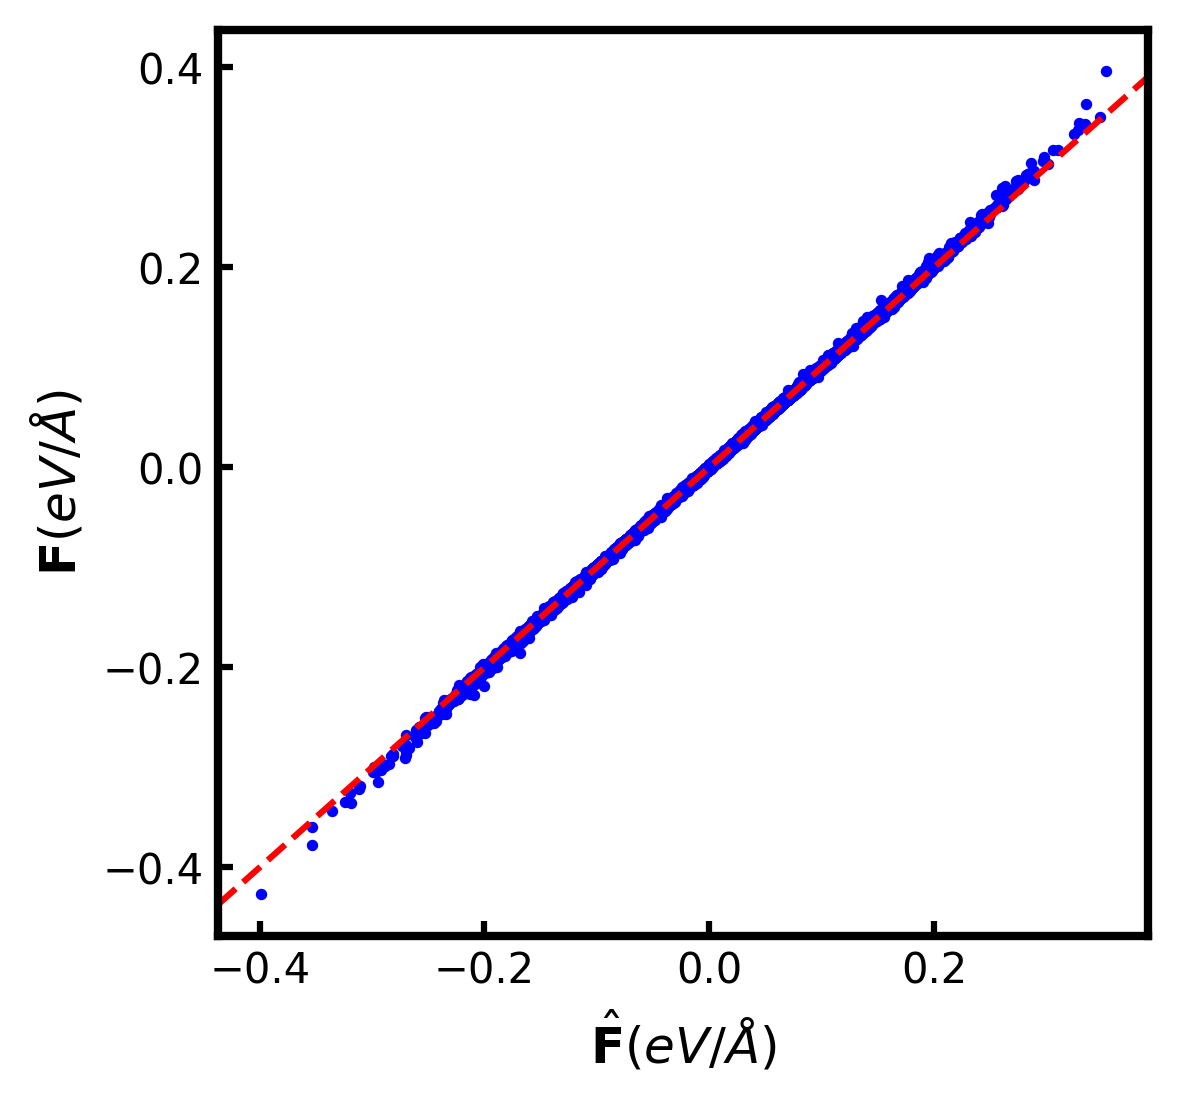

In [13]:
def add_identity( *line_args, **line_kwargs):
    axes = gca()
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes
fig = plt.figure(figsize=[4,4], dpi=300)

# set the basic properties
plt.xlabel(r'$\hat{\mathbf{F}} (eV/\AA)$', fontsize=12)
plt.ylabel(r'$\mathbf{F} (eV/\AA)$', fontsize=12)
plt.scatter(np.concatenate(force).reshape(-1), np.concatenate(force_gt).reshape(-1), color='b', s=3)
add_identity(color='r', ls='--')
frame_tick()
plt.show()

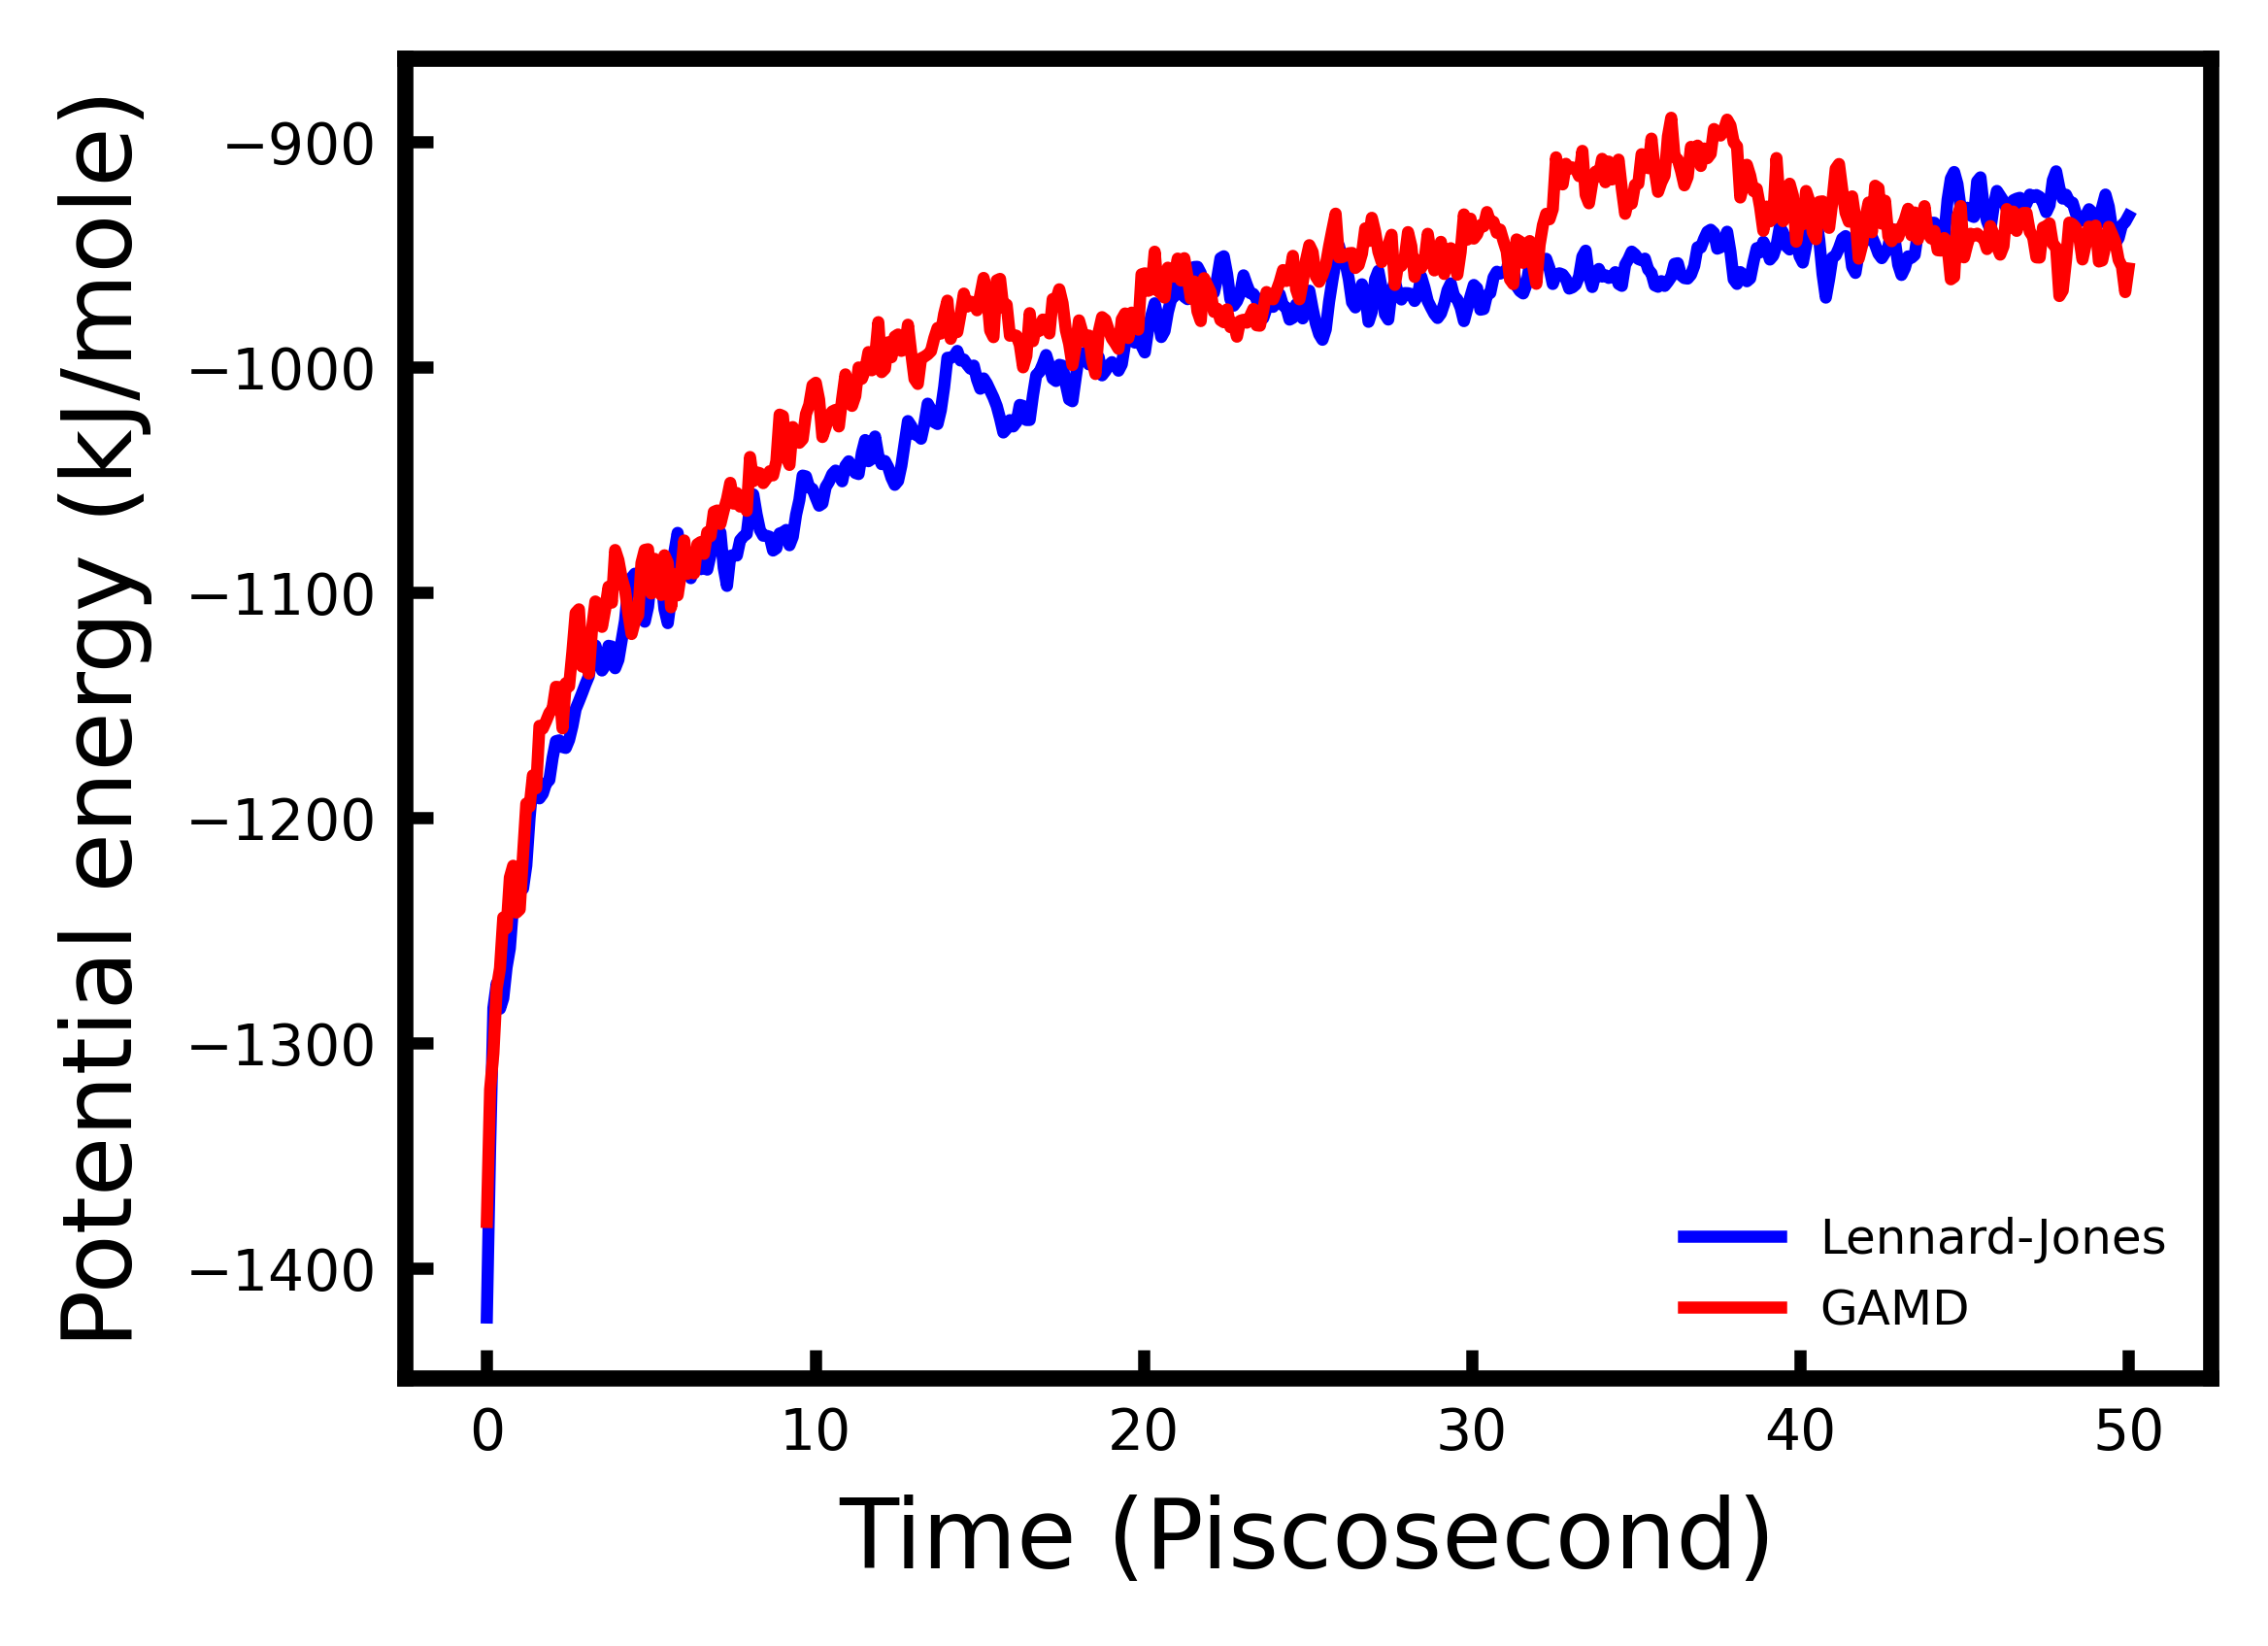

In [18]:
log_arr0 = np.loadtxt('./rollout_test/log_nvt_lj_gt.txt', dtype='str')
log_arr5 = np.loadtxt('./rollout_test/log_nvt_gnn_langevin_lj.txt', dtype='str')

fig, ax = plt.subplots(figsize=[4, 3], dpi=600)

plt.plot(np.linspace(0, 50.0, num=500), log_arr0[:, 3].astype(np.float32),
         label='Lennard-Jones',
         color='blue')
plt.plot(np.linspace(0, 50.0, num=500), log_arr5[:, 2].astype(np.float32),
         label='GAMD',
        color='red')
frame_tick()
ax.tick_params(axis='both', which='major', labelsize=7)
plt.xlabel('Time (Piscosecond)', fontsize=12)
plt.ylabel('Potential energy (kJ/mole)', fontsize=12)
legend('lower right', fontsize=6)
plt.show()

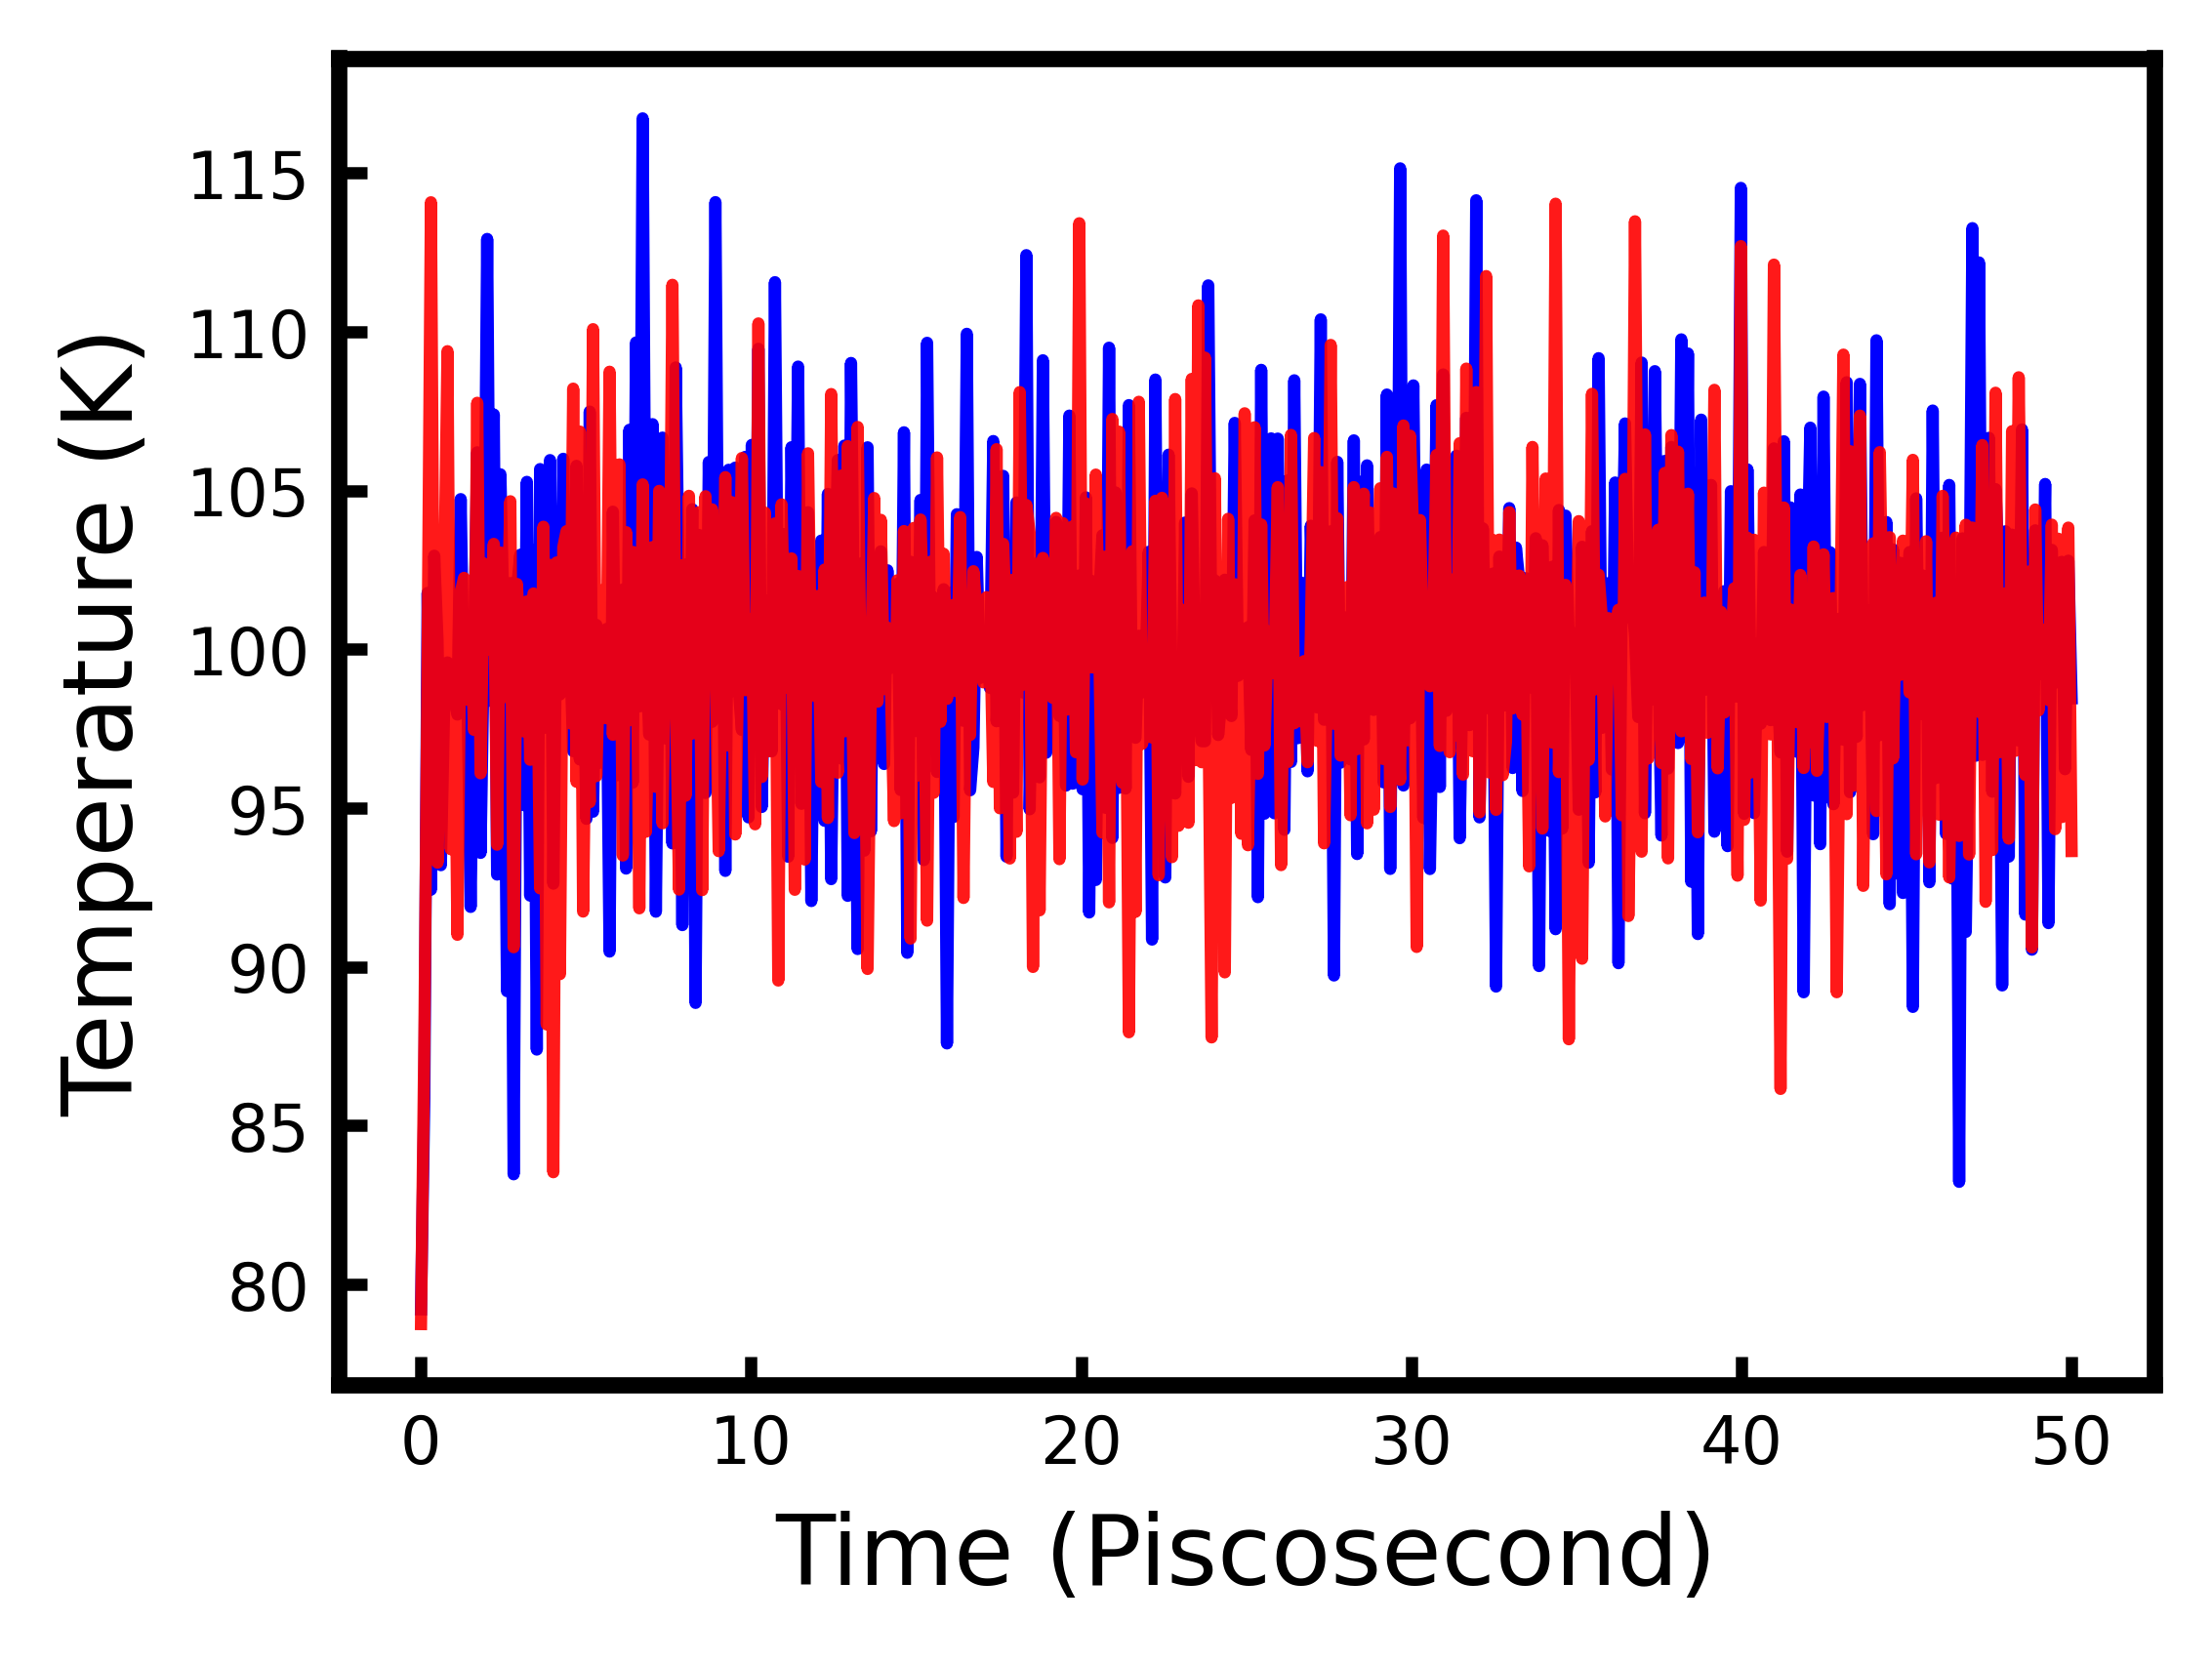

In [11]:
fig, ax = plt.subplots(figsize=[4, 3], dpi=600)

plt.plot(np.linspace(0, 50.0, num=500), log_arr0[:, 6].astype(np.float32),
         label='Lennard-Jones',
         color='blue')
plt.plot(np.linspace(0, 50.0, num=500), log_arr5[:, 5].astype(np.float32),
         label='GAMD',
        color='red',
        alpha=0.9)
frame_tick()
ax.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Time (Piscosecond)', fontsize=12)
plt.ylabel('Temperature (K)', fontsize=12)
plt.show()